### IMPORT

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",100)
from datetime import datetime

### LOAD DATASET

In [6]:
### a function to load (and concatene) informations from Parc_XX.csv
def create_df_parc_data(list_num_parc,list_date_parc):
    df_parc_data = pd.DataFrame()
    for num_parc in list_num_parc:
        for date_parc in list_date_parc:
            df_parc_data = df_parc_data.append(pd.read_csv("../data/Parc%s_%s.csv"%(num_parc,date_parc),sep=";",decimal=','),ignore_index=True)
    df_parc_data["Date"] = pd.to_datetime(df_parc_data["Date"], format = "%d/%m/%Y %H:%M")
    return df_parc_data

In [7]:
list_num_parc = [1,2,3]
list_date_parc = ["2015","2016","2017"]

In [8]:
df_parc_data = create_df_parc_data(list_num_parc,list_date_parc)

##### we create the Production_mean_hour variable : mean production per hour

In [9]:
### we create an ident for each hour "Date_hour_int"
df_parc_data["Date_hour_int"] = df_parc_data["Date"].dt.year*10**6  + df_parc_data["Date"].dt.month*10**4 +\
df_parc_data["Date"].dt.day*10**2 + df_parc_data["Date"].dt.hour
#### we create a dataframe with "production_mean_hour" value for each Eolienne*date_hour_int
df_product_mean = df_parc_data[df_parc_data["Fonctionnement"]==1].groupby(["Eolienne","Date_hour_int"])["Production"]\
                            .mean().reset_index().rename(columns={"Production":"Production_mean_hour"})

##### we add this value in the initial dataset "df_parc_data"
df_parc_data = pd.merge(df_parc_data,df_product_mean,on=["Eolienne","Date_hour_int"],how="left")

####  WEATHER's DATASET from prevMeteo

In [10]:
### a function to load (and concatene) informations from PrevMeteo_GrilleXX.xlsx
def create_df_meteo_from_list_grille(list_grille):
    df_meteo  = pd.DataFrame()
    for grille_C in list_grille:
        df_meteo_tmp =  pd.read_excel('../data/PrevMeteo_Grille%s.xlsx'%(grille_C),sep=';')
        df_meteo_tmp["grille"] = grille_C
        df_meteo = df_meteo.append(df_meteo_tmp,ignore_index=True)
    df_meteo["date"] = pd.to_datetime(df_meteo["date"],format = "%Y-%m-%d %H:%M:%S")
    df_meteo.rename(columns= {"date":"Date"},inplace=True)
    return df_meteo

In [11]:
# for weather's data,we can take the value of 16 different "grille" 
# some more data are available but with a very shalow history and will not be used for that model
list_grille= range(1,17)
df_meteo = create_df_meteo_from_list_grille(list_grille)

In [15]:
df_meteo.columns

Index(['Date', 'fc_hor', 'RS', 'CAPE', 'SP', 'CP', 'BLD', 'SSHF', 'SLHF',
       'MSL', 'BLH', 'TCC', 'U10', 'V10', 'T2', 'D2', 'SSRD', 'STRD', 'SSR',
       'STR', 'TSR', 'LCC', 'MCC', 'HCC', 'TSRC', 'SSRC', 'STRC', 'TP', 'FA',
       'U100', 'V100', 'vit_100', 'vit_10', 'dir_100', 'dir_10', 'grille'],
      dtype='object')

In [12]:
### the aim of this challenge is to predict the Production for tomorrow. 
# so, we keep only forecast (fc_hor) between 24h and 47h (Tomorrow's Forecast)
df_meteo = df_meteo[(df_meteo["fc_hor"]>=24) & (df_meteo["fc_hor"]<=47)].copy()

In [18]:
#no grid looks like very different from others and no clear outlier can be detected on basic stats
df_meteo.groupby('grille').describe()

BLD                                                              \
          count      mean       std       min       25%       50%       75%   
grille                                                                        
1       20040.0  3.857276  5.870726 -0.510586  0.647927  1.756638  4.561664   
2       20040.0  3.649206  5.618142 -0.352600  0.647082  1.717003  4.206957   
3       20040.0  3.521791  5.461182 -0.139266  0.614852  1.643322  4.042613   
4       20040.0  3.466649  5.373866 -0.127396  0.607107  1.616324  4.022296   
5       20040.0  3.817137  6.015286 -0.382951  0.640656  1.732086  4.381677   
6       20040.0  3.804832  5.940329 -0.297253  0.681380  1.741933  4.389718   
7       20040.0  3.729616  5.778428 -0.130944  0.678797  1.733676  4.350434   
8       20040.0  3.619226  5.548739 -0.103429  0.649672  1.718424  4.232700   
9       20040.0  4.094465  6.500921 -0.219574  0.711480  1.818763  4.632062   
10      20040.0  3.917896  6.104899 -0.113763  0.717810  1.812133  4.526059   
11      20040.0  3.862854  5.889742 -0.230174  0.730710  1.848754  4.546988   
12      20040.0  3.903265  5.867220 -0.089392  0.769980  1.894904  4.598845   
13      20040.0  4.171223  6.579269 -0.164274  0.714768  1.883932  4.703785   
14      20040.0  4.029005  6.275148 -0.297253  0.722079  1.860284  4.601419   
15      20040.0  4.042174  6.217809 -0.294062  0.739862  1.891519  4.670200   
16      20040.0  4.201360  6.422920 -0.075972  0.806011  1.989158  4.908739   

                       BLH                                                 \
              max    count        mean         std        min         25%   
grille                                                                      
1       80.012955  20040.0  548.005487  403.992091   9.900614  201.352352   
2       74.242706  20040.0  549.497582  411.654504  10.006572  194.497192   
3       71.980347  20040.0  550.521069  418.030384  10.139435  190.526119   
4       74.895905  20040.0  550.811646  422.910030   9.995536  187.614067   
5       79.657394  20040.0  550.887781  408.087233  10.103478  195.760548   
6       78.623436  20040.0  551.010991  412.164449  10.583779  193.380890   
7       76.131386  20040.0  549.712977  415.201584  10.491424  190.974312   
8       71.651390  20040.0  547.709625  416.165496  10.886895  188.564167   
9       82.004059  20040.0  549.793024  404.899904   9.858096  198.845062   
10      74.783440  20040.0  547.397163  404.834805  10.183240  196.771481   
11      73.926941  20040.0  545.771067  404.913452  10.089490  194.397442   
12      73.215836  20040.0  545.141878  404.272271   9.850322  197.181374   
13      82.572952  20040.0  550.776603  401.500080   9.924156  202.085129   
14      75.390732  20040.0  549.235786  401.398997  10.082590  200.614326   
15      72.906212  20040.0  549.003105  402.564021   9.944072  200.331360   
16      76.746246  20040.0  549.509686  403.452925  10.194072  202.321407   

                                                CAPE                         \
               50%         75%          max    count       mean         std   
grille                                                                        
1       467.340225  834.919479  2230.123779  20040.0  19.738590  117.322196   
2       461.652023  842.663940  2228.550537  20040.0  19.828295  119.480176   
3       458.029083  846.835770  2293.925537  20040.0  20.124882  122.334431   
4       452.628189  850.363251  2310.238037  20040.0  20.577547  125.087504   
5       472.500992  842.701187  2143.681641  20040.0  20.105204  118.651528   
6       468.165939  847.488235  2211.175537  20040.0  20.389604  120.598494   
7       462.073059  844.879074  2277.050537  20040.0  20.791209  123.212448   
8       455.952591  840.363815  2277.800537  20040.0  21.177133  125.872355   
9       475.261459  837.787720  2257.576416  20040.0  20.632076  118.019344   
10      470.712051  833.469040  2223.826416  20040.0  21.163384  120.419624   
11      466.229980 

In [51]:
#no missing data
df_meteo.isnull().sum()

Date       0
fc_hor     0
RS         0
CAPE       0
SP         0
CP         0
BLD        0
SSHF       0
SLHF       0
MSL        0
BLH        0
TCC        0
U10        0
V10        0
T2         0
D2         0
SSRD       0
STRD       0
SSR        0
STR        0
TSR        0
LCC        0
MCC        0
HCC        0
TSRC       0
SSRC       0
STRC       0
TP         0
FA         0
U100       0
V100       0
vit_100    0
vit_10     0
dir_100    0
dir_10     0
grille     0
dtype: int64

In [13]:
df_meteo_transp = df_meteo.set_index(['Date', 'grille']).unstack()

In [15]:
df_meteo_transp.head(1)

fc_hor                                                              \
grille         1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16   
Date                                                                            
2015-01-02     24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24   

                   RS                                                         \
grille             1          2          3          4          5          6    
Date                                                                           
2015-01-02  2739200.0  2761600.0  2775040.0  2770944.0  2595968.0  2617344.0   

                                                                              \
grille             7          8          9          10         11         12   
Date                                                                           
2015-01-02  2630016.0  2625280.0  2441088.0  2462464.0  2473600.0  2464256.0   

                                                       CAPE                 \
grille             13         14         15         16   1    2    3    4    
Date                                                                         
2015-01-02  2277248.0  2302848.0  2316800.0  2306944.0  0.0  0.0  0.0  0.0   

                                                                               \
grille            5         6         7         8      9         10        11   
Date                                                                            
2015-01-02  0.900391  0.404297  0.058594  0.013672  4.625  2.320312  0.626953   

                                                                  SP  \
grille           12     13        14       15        16           1    
Date                                                                   
2015-01-02  0.15625  4.625  4.921875  4.09375  1.023438  101224.6875   

                            ...        vit_100               vit_10            \
grille               2      ...             15         16        1         2    
Date                        ...                                                 
2015-01-02  101517.1875     ...      10.628591  10.769145  7.568475  6.991383   

                                                                       \
grille            3         4        5         6         7         8    
Date                                                                    
2015-01-02  6.506779  6.185162  6.87764  6.134895  5.613973  5.507491   

                                                                       \
grille            9         10        11        12       13        14   
Date                                                                    
2015-01-02  6.124305  5.727106  5.533918  5.700463  6.26307  6.039879   

                                   dir_100                          \
grille            15        16          1           2           3    
Date                                                                 
2015-01-02  5.912813  5.954444  222.436646  220.674973  218.611481   

                                                                        \
grille              4           5           6           7           8    
Date                                                                     
2015-01-02  216.168182  222.755798  220.696381  218.372635  216.056671   

                                                                        \
grille              9           10          11          12          13   
Date                                                                     
2015-01-02  222.570892  220.081161  217.771515  216.348495  221.826691   

                                                    dir_10              \
grille              14          15          16          1           2    
Date                                                                     
2015-01-02  219.805023  218.294662  218.012589  218.203568  215.399414   

                                  

In [16]:
#flatten columns names
df_meteo_transp.columns = ['_'.join(map(str,col)) for col in df_meteo_transp.columns.values]

In [23]:
df_meteo_transp.head(1)

,fc_hor_1,fc_hor_2,fc_hor_3,fc_hor_4,fc_hor_5,fc_hor_6,fc_hor_7,fc_hor_8,fc_hor_9,fc_hor_10,fc_hor_11,fc_hor_12,fc_hor_13,fc_hor_14,fc_hor_15,fc_hor_16,RS_1,RS_2,RS_3,RS_4,RS_5,RS_6,RS_7,RS_8,RS_9,RS_10,RS_11,RS_12,RS_13,RS_14,RS_15,RS_16,CAPE_1,CAPE_2,CAPE_3,CAPE_4,CAPE_5,CAPE_6,CAPE_7,CAPE_8,CAPE_9,CAPE_10,CAPE_11,CAPE_12,CAPE_13,CAPE_14,CAPE_15,CAPE_16,SP_1,SP_2,...,vit_100_15,vit_100_16,vit_10_1,vit_10_2,vit_10_3,vit_10_4,vit_10_5,vit_10_6,vit_10_7,vit_10_8,vit_10_9,vit_10_10,vit_10_11,vit_10_12,vit_10_13,vit_10_14,vit_10_15,vit_10_16,dir_100_1,dir_100_2,dir_100_3,dir_100_4,dir_100_5,dir_100_6,dir_100_7,dir_100_8,dir_100_9,dir_100_10,dir_100_11,dir_100_12,dir_100_13,dir_100_14,dir_100_15,dir_100_16,dir_10_1,dir_10_2,dir_10_3,dir_10_4,dir_10_5,dir_10_6,dir_10_7,dir_10_8,dir_10_9,dir_10_10,dir_10_11,dir_10_12,dir_10_13,dir_10_14,dir_10_15,dir_10_16
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,2739200.0,2761600.0,2775040.0,2770944.0,2595968.0,2617344.0,2630016.0,2625280.0,2441088.0,2462464.0,2473600.0,2464256.0,2277248.0,2302848.0,2316800.0,2306944.0,0.0,0.0,0.0,0.0,0.900391,0.404297,0.058594,0.013672,4.625,2.320312,0.626953,0.15625,4.625,4.921875,4.09375,1.023438,101224.6875,101517.1875,...,10.628591,10.769145,7.568475,6.991383,6.506779,6.185162,6.87764,6.134895,5.613973,5.507491,6.124305,5.727106,5.533918,5.700463,6.26307,6.039879,5.912813,5.954444,222.436646,220.674973,218.611481,216.168182,222.755798,220.696381,218.372635,216.056671,222.570892,220.081161,217.771515,216.348495,221.826691,219.805023,218.294662,218.012589,218.203568,215.399414,212.328064,209.321396,218.296875,215.037125,211.440704,208.501144,216.60022,212.698227,209.50795,208.699112,215.416061,212.681503,210.985718,211.718033


In [21]:
#drop hor_* variables
df_meteo_transp.drop(df_meteo_transp.columns[:16], axis=1, inplace=True)

### we create df_all (concatenation of train and test)
it's the dataset for the model.

In [23]:
### we keep only one row per hour (minute =0)
### we keep only one row where the wind turbine is working (Fonctionnement =1)
### we keep only usefull columns
list_col_parc_data_to_keep = ["Date","Eolienne","Fonctionnement","Production_mean_hour"]
df_all = df_parc_data[(df_parc_data["Date"].dt.minute == 0) & (df_parc_data["Fonctionnement"] == 1)]\
[list_col_parc_data_to_keep].copy()

In [24]:
print (df_all.shape)
df_all.head(3)

(215158, 4)


,Date,Eolienne,Fonctionnement,Production_mean_hour
0,2015-01-01 00:00:00,Turb3,1,121.923333
60,2015-01-01 01:00:00,Turb3,1,210.081667
120,2015-01-01 02:00:00,Turb3,1,255.016667


#### we add weather's variable

In [25]:
df_all.set_index('Date', inplace=True)

In [26]:
df_all = pd.merge(df_all, df_meteo_transp, left_index=True, right_index=True)

In [27]:
df_all.head(2)

,Eolienne,Fonctionnement,Production_mean_hour,RS_1,RS_2,RS_3,RS_4,RS_5,RS_6,RS_7,RS_8,RS_9,RS_10,RS_11,RS_12,RS_13,RS_14,RS_15,RS_16,CAPE_1,CAPE_2,CAPE_3,CAPE_4,CAPE_5,CAPE_6,CAPE_7,CAPE_8,CAPE_9,CAPE_10,CAPE_11,CAPE_12,CAPE_13,CAPE_14,CAPE_15,CAPE_16,SP_1,SP_2,SP_3,SP_4,SP_5,SP_6,SP_7,SP_8,SP_9,SP_10,SP_11,SP_12,SP_13,SP_14,SP_15,...,vit_100_15,vit_100_16,vit_10_1,vit_10_2,vit_10_3,vit_10_4,vit_10_5,vit_10_6,vit_10_7,vit_10_8,vit_10_9,vit_10_10,vit_10_11,vit_10_12,vit_10_13,vit_10_14,vit_10_15,vit_10_16,dir_100_1,dir_100_2,dir_100_3,dir_100_4,dir_100_5,dir_100_6,dir_100_7,dir_100_8,dir_100_9,dir_100_10,dir_100_11,dir_100_12,dir_100_13,dir_100_14,dir_100_15,dir_100_16,dir_10_1,dir_10_2,dir_10_3,dir_10_4,dir_10_5,dir_10_6,dir_10_7,dir_10_8,dir_10_9,dir_10_10,dir_10_11,dir_10_12,dir_10_13,dir_10_14,dir_10_15,dir_10_16
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,Turb3,1,789.378500,2739200.0,2761600.0,2775040.0,2770944.0,2595968.0,2617344.0,2630016.0,2625280.0,2441088.0,2462464.0,2473600.0,2464256.0,2277248.0,2302848.0,2316800.0,2306944.0,0.0,0.0,0.0,0.0,0.900391,0.404297,0.058594,0.013672,4.625,2.320312,0.626953,0.15625,4.625,4.921875,4.09375,1.023438,101224.6875,101517.1875,101763.1875,101915.6875,101872.6875,101901.6875,101896.1875,101823.6875,102055.6875,101835.1875,101623.1875,101427.1875,102114.1875,101866.6875,101624.1875,...,10.628591,10.769145,7.568475,6.991383,6.506779,6.185162,6.87764,6.134895,5.613973,5.507491,6.124305,5.727106,5.533918,5.700463,6.26307,6.039879,5.912813,5.954444,222.436646,220.674973,218.611481,216.168182,222.755798,220.696381,218.372635,216.056671,222.570892,220.081161,217.771515,216.348495,221.826691,219.805023,218.294662,218.012589,218.203568,215.399414,212.328064,209.321396,218.296875,215.037125,211.440704,208.501144,216.60022,212.698227,209.50795,208.699112,215.416061,212.681503,210.985718,211.718033
2015-01-02,Turb4,1,688.904167,2739200.0,2761600.0,2775040.0,2770944.0,2595968.0,2617344.0,2630016.0,2625280.0,2441088.0,2462464.0,2473600.0,2464256.0,2277248.0,2302848.0,2316800.0,2306944.0,0.0,0.0,0.0,0.0,0.900391,0.404297,0.058594,0.013672,4.625,2.320312,0.626953,0.15625,4.625,4.921875,4.09375,1.023438,101224.6875,101517.1875,101763.1875,101915.6875,101872.6875,101901.6875,101896.1875,101823.6875,102055.6875,101835.1875,101623.1875,101427.1875,102114.1875,101866.6875,101624.1875,...,10.628591,10.769145,7.568475,6.991383,6.506779,6.185162,6.87764,6.134895,5.613973,5.507491,6.124305,5.727106,5.533918,5.700463,6.26307,6.039879,5.912813,5.954444,222.436646,220.674973,218.611481,216.168182,222.755798,220.696381,218.372635,216.056671,222.570892,220.081161,217.771515,216.348495,221.826691,219.805023,218.294662,218.012589,218.203568,215.399414,212.328064,209.321396,218.296875,215.037125,211.440704,208.501144,216.60022,212.698227,209.50795,208.699112,215.416061,212.681503,210.985718,211.718033


#### we keep only value after 2015_1_3 to avoid missing values

In [28]:
df_all = df_all[df_all.index > datetime(2015,1,3)].copy()
df_all.sort_index(ascending=1, inplace=True)

### MACHINE LEARNING


#### we create the train/val split
The objective is now to create a dataset to train a model and a dataset to evaluate our model.

In [29]:
date_split_val = datetime(2016,1,1)
date_split_test = datetime(2017,1,1)

In [30]:
df_all_train = df_all[df_all.index < date_split_val]
df_all_val = df_all[(df_all.index >= date_split_val) & (df_all.index < date_split_test)]

#### for the moment, we keep all variables

In [33]:
list_col_model = list(df_all_train.columns[4:])
col_target = "Production_mean_hour"

#### for this notebook, we will use a linear model

In [138]:
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso
#from sklearn.linear_model import ElasticNet
# check : from sklearn.linear_model import ElasticNetCV

In [160]:
#model = LinearRegression()
#model = Lasso(alpha=0.1, copy_X=False, normalize=True, max_iter=10000, precompute=True)
#model = ElasticNet(alpha = 0.1, l1_ratio=1, normalize=True, precompute=True, max_iter=10000, copy_X=False, tol=0.0001)

#### Fit one model by turbine on the train dataset (2015)
A lasso is performed first in order to perform an effective feature selection

##### preprocessing

In [68]:
#could be helpful to normalize data before if variable multiplication are used in the model
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)

In [75]:
#Memory issue when transforming the full data set at once
#Should be handled in preprocessing step of pipeline
#Model should be rebuilt to treat each grid file separatly and then blending step will agregate all models together
#log transform (or other) should be tested

#reprocess import phase and slice data by turbine / grid
#then construct dictionnary of pipeline
#try a PCA in the pipeline
#ensemble : see how to select/blend models
#try XGBoost


X_train = poly.fit_transform(df_all_train.loc[df_all_train["Eolienne"] == "Turb1", list_col_model])

In [79]:
X_train[0:2,:]

array([[  1.00000000e+00,   1.78060800e+06,   1.65990400e+06, ...,
          4.22266879e+04,   4.38867949e+04,   4.56121676e+04],
       [  1.00000000e+00,   1.78060800e+06,   1.65990400e+06, ...,
          4.09550601e+04,   4.17403878e+04,   4.25407746e+04]])

In [77]:
X_test = poly.fit_transform(df_all_val.loc[df_all_val["Eolienne"] == "Turb1", list_col_model])

In [57]:
from sklearn.linear_model import Lasso
#one model for each turbine
#turbines = ['Turb1', 'Turb2', 'Turb3', 'Turb4', 'Turb5', 'Turb6', 'Turb7', 'Turb8', 'Turb9', 'Turb10', 'Turb11']
turbines = ['Turb1']
#models = {turbine :  ElasticNet(alpha = 0.1, l1_ratio=1, normalize=True, max_iter=1000, copy_X=False) for turbine in turbines}
models = {turbine :  Lasso(alpha=0.2, copy_X=False, normalize=True, max_iter=10000, precompute=True) for turbine in turbines}

In [58]:
for turbine, model in models.items():
    train = X_train[X_train["Eolienne"] == turbine]
    model.fit(X, train[col_target])

In [59]:
print(models['Turb1'].sparse_coef_)

  (0, 0)	3.9287136258e-06
  (0, 20)	0.0284100352858
  (0, 27)	0.0482952381204
  (0, 47)	3342.59892002
  (0, 59)	1204.13822012
  (0, 66)	3.03061370317
  (0, 74)	10.2292273256
  (0, 86)	0.0191633542517
  (0, 90)	0.133137579451
  (0, 115)	0.000993971845657
  (0, 127)	0.00445133719582
  (0, 130)	0.0309770212601
  (0, 139)	0.0875269314659
  (0, 142)	0.0170447292603
  (0, 143)	-7.30118110226
  (0, 144)	-19.2725410211
  (0, 146)	-41.0816956254
  (0, 150)	-9.15085995418
  (0, 156)	-0.839100204741
  (0, 207)	-6.36028669171
  (0, 211)	-1.65094219748
  (0, 330)	1.61510102951
  (0, 370)	-0.15260949326
  (0, 452)	-5.27675590709
  (0, 466)	14.7527834261
  (0, 470)	21.9309855249
  (0, 475)	29.1525941091
  (0, 482)	14.8696694579
  (0, 486)	63.8089517298
  (0, 491)	4.20144614388
  (0, 516)	-0.0323734850655


In [60]:
a = models['Turb1'].sparse_coef_

In [61]:
train[list_col_model].columns[a.indices]

Index(['RS_2', 'CAPE_6', 'CAPE_13', 'CP_1', 'CP_13', 'BLD_4', 'BLD_12',
       'SSHF_8', 'SSHF_12', 'MSL_5', 'BLH_1', 'BLH_4', 'BLH_13', 'BLH_16',
       'TCC_1', 'TCC_2', 'TCC_4', 'TCC_8', 'TCC_14', 'D2_1', 'D2_5', 'MCC_12',
       'SSRC_4', 'V100_6', 'vit_100_4', 'vit_100_8', 'vit_100_13', 'vit_10_4',
       'vit_10_8', 'vit_10_13', 'dir_10_6'],
      dtype='object')

Selected variables with precompute = true :
Index(['RS_2', 'CAPE_6', 'CAPE_13', 'CP_1', 'CP_13', 'BLD_4', 'BLD_12',
       'SSHF_8', 'SSHF_12', 'MSL_5', 'BLH_1', 'BLH_4', 'BLH_13', 'BLH_16',
       'TCC_1', 'TCC_2', 'TCC_4', 'TCC_8', 'TCC_14', 'D2_1', 'D2_5', 'MCC_12',
       'SSRC_4', 'V100_6', 'vit_100_4', 'vit_100_8', 'vit_100_13', 'vit_10_4',
       'vit_10_8', 'vit_10_13', 'dir_10_6'],
      dtype='object')

#### we predict on the validation dataset (2016)

In [62]:
list_col_pred_val = list(set(["Eolienne", col_target] + list_col_model))

In [63]:
#prediction has to be between 0 and 2000
df_pred_val = pd.DataFrame(columns=df_all_val.columns)

for turbine in models:
    df_pred_chunk = df_all_val.loc[df_all_val["Eolienne"] == turbine, list_col_pred_val]
    df_pred_chunk["pred"] = list(map(lambda x : max(min(x, 2000), 0), models[turbine].predict(df_pred_chunk[list_col_model])))
    df_pred_val = df_pred_val.append(df_pred_chunk)

#### we evaluate our prediction

In [40]:
from sklearn.metrics import mean_absolute_error
import numpy as np

In [64]:
#Benchmark is 259.4
mean_absolute_error(df_pred_val[col_target],df_pred_val["pred"])

207.54883340363759

In [42]:
df_pred_val[["Eolienne", col_target, "pred"]]

,Eolienne,Production_mean_hour,pred
2016-01-01 00:00:00,Turb1,587.974000,530.582456
2016-01-01 01:00:00,Turb1,617.068333,365.084705
2016-01-01 02:00:00,Turb1,398.496000,303.280738
2016-01-01 03:00:00,Turb1,375.554667,190.853804
2016-01-01 04:00:00,Turb1,153.340000,90.562185
2016-01-01 05:00:00,Turb1,30.796429,116.645776
2016-01-01 06:00:00,Turb1,-5.020000,8.827267
2016-01-01 07:00:00,Turb1,-2.338333,0.000000
2016-01-01 08:00:00,Turb1,2.065000,0.000000
2016-01-01 09:00:00,Turb1,84.873333,135.192347


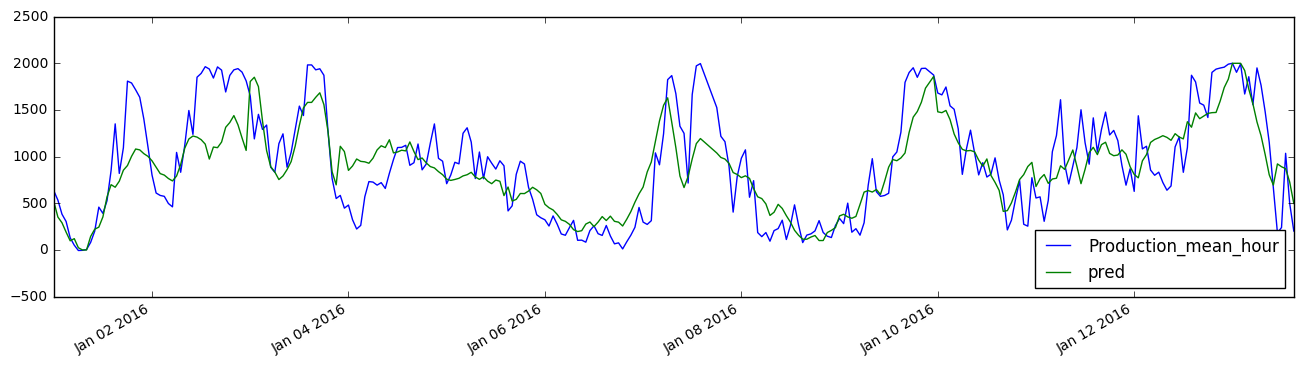

In [43]:
eolienne_C = "Turb2"
df_pred_val[df_pred_val["Eolienne"] == eolienne_C][["Production_mean_hour", "pred"]].iloc[0:300].plot(figsize=(16,4))

#### we predict on the test

In [ ]:
df_all_test = df_all[(df_all["Date"]>=date_split_test)].copy()

In [ ]:
list_col_pred_test = list(set(["Date","Eolienne"]+list_col_model))
df_pred_test = df_all_test[list_col_pred_test].copy()

In [ ]:
df_pred_test["pred"] = model.predict(df_all_test[list_col_model])

##### we create the submit_file

In [ ]:
df_pred_test[["Date","Eolienne","pred"]].to_csv("../data/submit_benchmark.csv",sep=";",index=False)

In [ ]:
pd.read_csv("../data/submit_benchmark.csv",sep=";",nrows=5)